<a href="https://colab.research.google.com/github/Sweta-Das/Creating_Multitask_Models_Using_Keras/blob/main/Creating_Multi_task_Models_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Multi-task Models using Keras


In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil # Shutil = Shell Utilities; Higher level file operations

# Exception Handling

try:
  shutil.rmtree('logs')
except:
  pass

  shutil.rmtree() => deletes an entire directory tree; <br/>
  Syntax: shutil.rmtree(path, ignore_errors=False, onerror=None)<br/>
  <br/>
  path => points to a dir. <br/>
  If ignore_errors=True, errors due to failed removals will be ignored. If ignore_errors=False, errors are handled by handler specified<br/>
  by onerror, or if omitted, it raises an exception.

### Task - 1: Creating a dataset

In [2]:
# Using Keras Dataset to download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# print(x_test)

We are not going to use MNIST dataset directly, we're going to synthesize new dataset from it.

In [8]:
def create_example(x, y):  # here, x= image of mnist dataset; y=label of mnist dataset
  c = np.random.randint(0, 2) # randomly assign random int either c = 0 or 1

  # Assigning colored label to mnist dataset
  image = 0.5 * np.random.rand(28, 28, 3) # for colored label, 28*28 = dim of each instance in mnist dataset & 3 signify RGB color
  image[:, :, c] += 0.5 * x / 255.  # This'll show mnist example value only for Red & Green color. The calculation will normalize the value of instance to 0 or 1.
  return image, y, c

digit: 4, color: green


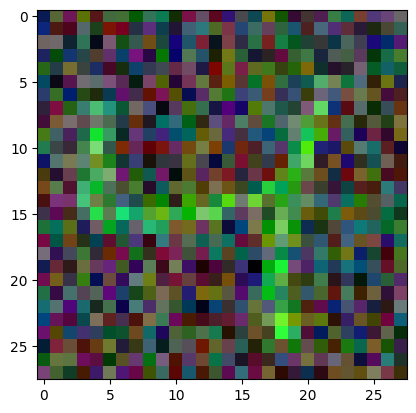

In [12]:
# Dictionary to keep track of color labels
colors = {0: 'red', 1: 'green'}

x, y, c = create_example(x_train[2], y_train[9])
print(f'digit: {y}, color: {colors[c]}') # displaying digit with its color

# Plotting image
plt.imshow(x)
plt.show()

### Task - 2: Dataset Generator

In [13]:
# For training & testing the dataset
def generate_data(x, y, batch_size= 32):

  # total number of examples = length of labels/examples
  num_examples = len(y)

  # For generator
  while True:

    # Input
    x_batch = np.zeros((batch_size, 28, 28, 3))

    # Output (0-9)
    y_batch = np.zeros((batch_size,)) # y ranges 0-9

    # Color (0 : 'red', 1 : 'Green')
    c_batch = np.zeros((batch_size,))

    # Generating examples to populate x_batch, y_batch & c_batch
    for i in range(0, batch_size):

      # Picking some random examples & passing it to create_example()
      index = np.random.randint(0, num_examples)
      image, digit, color = create_example(x[index], y[index])

      # Collecting new examples into batches
      x_batch[i] = image
      y_batch[i] = digit
      c_batch[i] = color

    # Return input, output & color
    yield x_batch, [y_batch, c_batch]

NOTE: Since, the x_batch, [y_batch, c_batch] are in tensor. The yield at the end of the program doesn't mean appended list for y_batch, & c_batch but, rather it means that y_batch in its entirety is the 1st element. And c_batch in its entirety is the 2nd one.

In [15]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size= 1))

[5.] [1.]


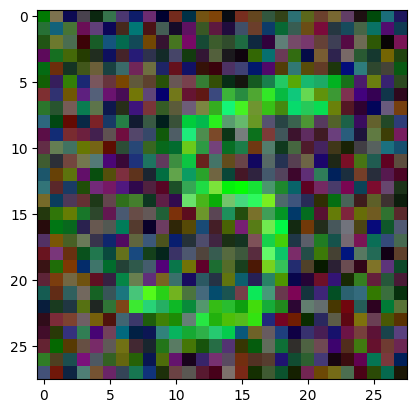

In [16]:
print(y, c)
plt.imshow(x[0]);

### Task-3: Create Model